<a href="https://colab.research.google.com/github/KoushikVGitHub/WESAD-Stress-detection/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix


class WESADDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.drop('subject', axis=1)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)

In [2]:
feats =   ['BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
           'EDA_phasic_mean', 'EDA_phasic_std', 'EDA_phasic_min', 'EDA_phasic_max', 'EDA_smna_mean',
           'EDA_smna_std', 'EDA_smna_min', 'EDA_smna_max', 'EDA_tonic_mean',
           'EDA_tonic_std', 'EDA_tonic_min', 'EDA_tonic_max', 'Resp_mean',
           'Resp_std', 'Resp_min', 'Resp_max', 'TEMP_mean', 'TEMP_std', 'TEMP_min',
           'TEMP_max', 'TEMP_slope', 'BVP_peak_freq', 'age', 'height',
           'weight','subject', 'label']
layer_1_dim = len(feats) -2
print(layer_1_dim)

29


In [3]:
file_path = '/content/drive/MyDrive/WESAD_processed_data/m14_merged.csv'

In [29]:
def get_data_loaders(subject_id, train_batch_size=25, test_batch_size=5):
    df = pd.read_csv(file_path, index_col=0)[feats]

    train_df = df[ df['subject'] != subject_id].reset_index(drop=True)
    test_df = df[ df['subject'] == subject_id].reset_index(drop=True)

    train_dset = WESADDataset(train_df)
    test_dset = WESADDataset(test_df)

    train_loader = torch.utils.data.DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=test_batch_size)

    return train_loader, test_loader

In [40]:
def calculate_permutation_importance(model, test_loader, original_accuracy, criterion, device, feature_list, test_df):
    """
    Calculates permutation importance using the correct feature set.
    """
    model.eval()
    importances = {}

    # FIX: Ensure we are only using the 29 features the model was trained on.
    # The 'feature_list' argument should be the list of 29 feature names.
    df_for_testing = test_df[feature_list + ['label', 'subject']]

    for feature_name in feature_list:
        temp_df = df_for_testing.copy()

        # Shuffle a single feature column
        temp_df[feature_name] = np.random.permutation(temp_df[feature_name])

        # Create a new dataloader with the shuffled data
        shuffled_dataset = WESADDataset(temp_df)
        shuffled_loader = torch.utils.data.DataLoader(shuffled_dataset, batch_size=test_loader.batch_size)

        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in shuffled_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images.float())
                _, argmax = torch.max(outputs, 1)
                correct += (labels == argmax).sum().item()
                total += len(labels)

        # Importance is the drop in accuracy
        importances[feature_name] = original_accuracy - (correct / total)

    return importances

In [41]:
class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(layer_1_dim, 128),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(256, 3),
                        #nn.Dropout(0.5),
                        nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.fc(x)

In [42]:
def train(model, optimizer, train_loader, validation_loader):
    history = {'train_loss': {}, 'train_acc': {}, 'valid_loss': {}, 'valid_acc': {}}
    #
    for epoch in range(num_epochs):

        # Train:
        total = 0
        correct = 0
        trainlosses = []

        for batch_index, (images, labels) in enumerate(train_loader):

            # Send to GPU (device)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images.float())

            # Loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trainlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

        history['train_loss'][epoch] = np.mean(trainlosses)
        history['train_acc'][epoch] = correct/total

        if epoch % 10 == 0:
            with torch.no_grad():

                losses = []
                total = 0
                correct = 0

                for images, labels in validation_loader:
                    #
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images.float())
                    loss = criterion(outputs, labels)

                    # Compute accuracy
                    _, argmax = torch.max(outputs, 1)
                    correct += (labels == argmax).sum().item() #.mean()
                    total += len(labels)

                    losses.append(loss.item())

                history['valid_acc'][epoch] = np.round(correct/total, 3)
                history['valid_loss'][epoch] = np.mean(losses)

                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

    return history

In [43]:
def test(model, validation_loader):
    print('Evaluating model...')
    model.eval()
    total, correct = 0, 0
    testlosses, correct_labels, predictions = [], [], []

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(validation_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            testlosses.append(loss.item())

            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total += len(labels)

            correct_labels.extend(labels.cpu().numpy())
            predictions.extend(argmax.cpu().numpy())

    test_loss = np.mean(testlosses)
    accuracy = np.round(correct/total, 2)
    print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

    cm = confusion_matrix(correct_labels, predictions)
    # MODIFIED: Return y_true and y_pred for error analysis
    return cm, test_loss, accuracy, correct_labels, predictions

In [44]:
# Batch sizes
train_batch_size = 25
test_batch_size = 5

# Learning Rate
learning_rate = 5e-3

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of Epochs
num_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

df = pd.read_csv(file_path, index_col=0)
subject_id_list = df['subject'].unique()

feature_names_for_importance = [f for f in feats if f not in ['subject', 'label']]

histories = []
confusion_matrices = []
test_losses = []
test_accs = []
all_errors = []
all_importances = []

for subject_id in subject_id_list:
    print(f'\n--- Processing Subject: {subject_id} ---')
    model = StressNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Get the original test dataframe for this fold
    test_df_fold = df[df['subject'] == subject_id].reset_index(drop=True)
    train_loader, test_loader = get_data_loaders(subject_id)

    # Train and test the model
    history = train(model, optimizer, train_loader, test_loader)
    cm, test_loss, test_acc, y_true, y_pred = test(model, test_loader) # MODIFIED: test() now returns y_true, y_pred

    # Store results
    histories.append(history)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    confusion_matrices.append(cm)

    # --- NEW: Perform Permutation Importance ---
    print(f'Calculating permutation importance for Subject {subject_id}...')
    importances = calculate_permutation_importance(model, test_loader, test_acc, criterion, device, feature_names_for_importance, test_df_fold)
    all_importances.append(importances)

    # --- NEW: Perform Error Analysis ---
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error_indices = np.where(y_true != y_pred)[0]
    error_df = test_df_fold.iloc[error_indices].copy()
    error_df['predicted_label'] = y_pred[error_indices]
    error_df['true_label'] = y_true[error_indices]
    all_errors.append(error_df)

# --- Post-loop processing ---
print("\n--- Cross-validation finished. Analyzing results. ---")
error_analysis_df = pd.concat(all_errors)
importance_df = pd.DataFrame(all_importances)


--- Processing Subject: 2 ---
Epoch [1/100], Loss: 1.299, Acc: 0.54
Epoch [11/100], Loss: 0.875, Acc: 0.58
Epoch [21/100], Loss: 1.134, Acc: 0.42
Epoch [31/100], Loss: 2.601, Acc: 0.46
Epoch [41/100], Loss: 0.5766, Acc: 0.79
Epoch [51/100], Loss: 0.3964, Acc: 0.8
Epoch [61/100], Loss: 0.7966, Acc: 0.67
Epoch [71/100], Loss: 0.05557, Acc: 0.97
Epoch [81/100], Loss: 0.507, Acc: 0.84
Epoch [91/100], Loss: 0.7906, Acc: 0.66
Evaluating model...
Loss: 0.1416, Acc: 0.93
Calculating permutation importance for Subject 2...

--- Processing Subject: 3 ---
Epoch [1/100], Loss: 1.258, Acc: 0.53
Epoch [11/100], Loss: 0.736, Acc: 0.58
Epoch [21/100], Loss: 0.6181, Acc: 0.69
Epoch [31/100], Loss: 0.1574, Acc: 0.95
Epoch [41/100], Loss: 0.1644, Acc: 0.91
Epoch [51/100], Loss: 0.04524, Acc: 0.99
Epoch [61/100], Loss: 0.6493, Acc: 0.58
Epoch [71/100], Loss: 0.1151, Acc: 0.97
Epoch [81/100], Loss: 0.4241, Acc: 0.81
Epoch [91/100], Loss: 0.03416, Acc: 1.0
Evaluating model...
Loss: 0.1738, Acc: 0.96
Calcul

In [45]:
np.mean(test_accs)

np.float64(0.9286666666666665)

In [46]:
np.mean(test_losses)

np.float64(0.175649962170713)

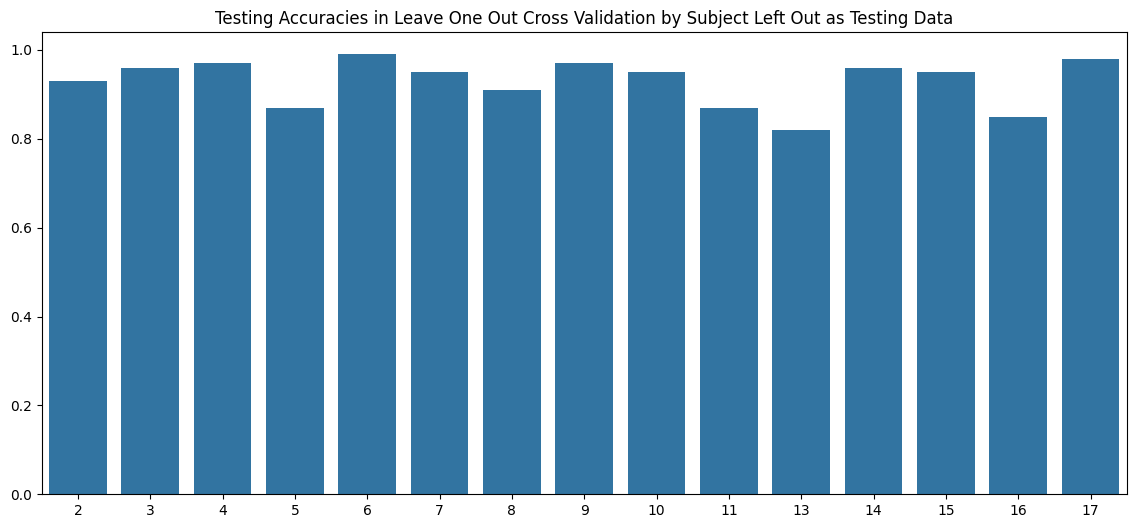

In [47]:
plt.figure(figsize=(14, 6))
plt.title('Testing Accuracies in Leave One Out Cross Validation by Subject Left Out as Testing Data')
sns.barplot(x=subject_id_list, y=test_accs);

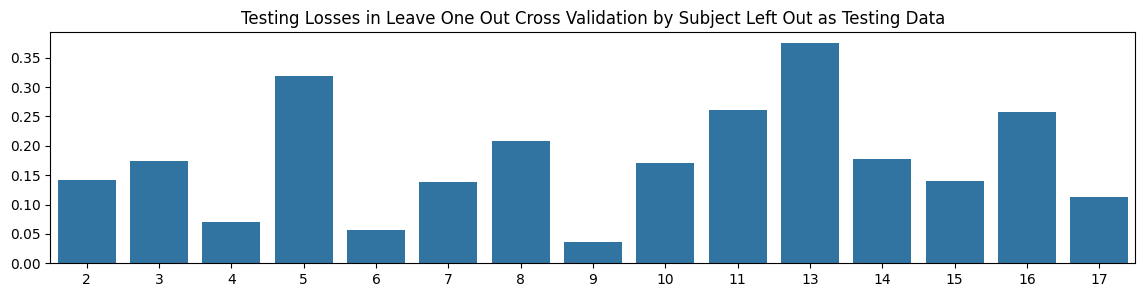

In [48]:
plt.figure(figsize=(14, 3))
plt.title('Testing Losses in Leave One Out Cross Validation by Subject Left Out as Testing Data')
sns.barplot(x=subject_id_list, y=test_losses);

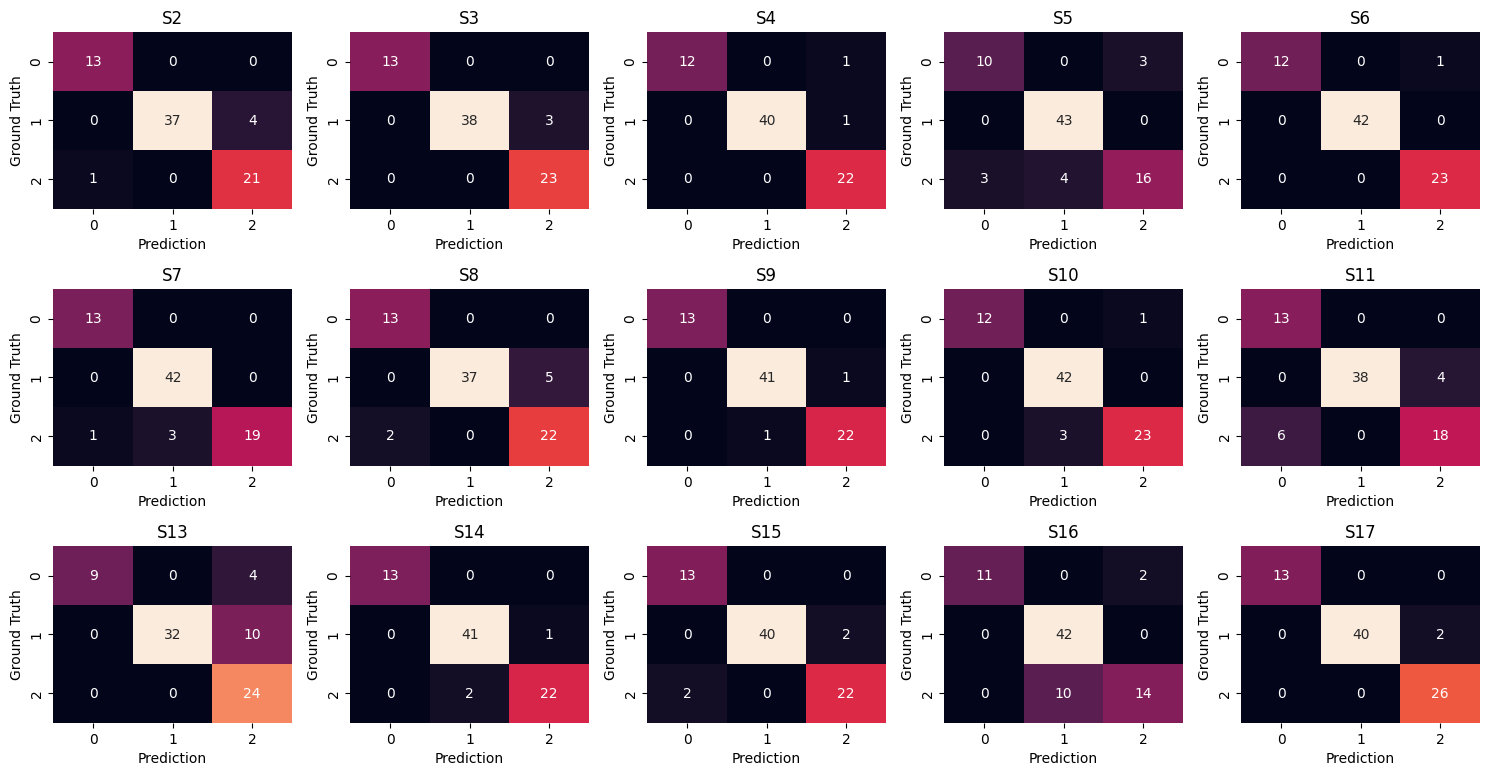

In [49]:
plt.figure(figsize=(15,10))

for i in range(15):
    plt.subplot(4,5 ,i+1)
    cm = confusion_matrices[i]


    sns.heatmap(cm, annot=True, fmt='d', cbar=False);
    plt.title(f'S{subject_id_list[i]}')
    plt.xlabel('Prediction');
    plt.ylabel('Ground Truth');
plt.tight_layout();

In [55]:
from sklearn.metrics import classification_report

target_names = ['Amusement', 'Baseline', 'Stress']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Amusement       1.00      1.00      1.00        13
    Baseline       1.00      0.95      0.98        42
      Stress       0.93      1.00      0.96        26

    accuracy                           0.98        81
   macro avg       0.98      0.98      0.98        81
weighted avg       0.98      0.98      0.98        81



In [54]:
torch.save(model.state_dict(), 'WESAD_model_V2.pt')

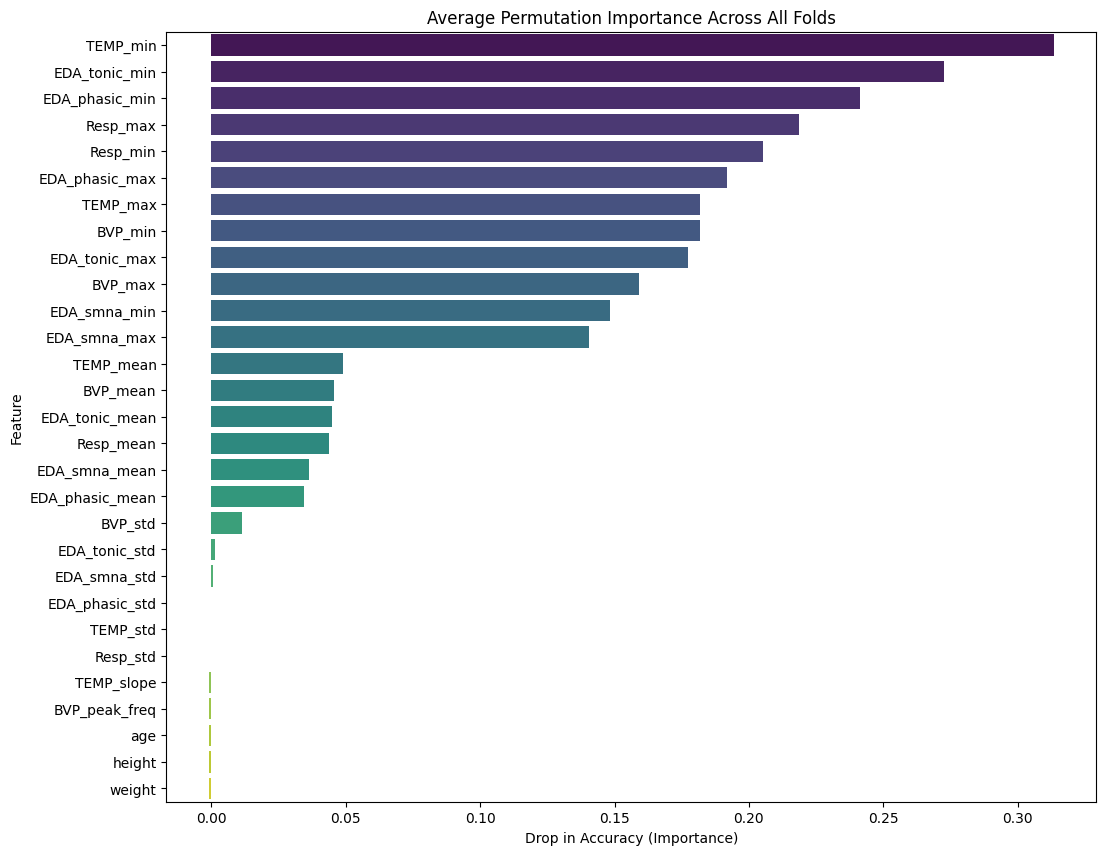

In [50]:
# --- Analyze and Plot Permutation Importance ---
# Average the importance scores across all folds
mean_importances = importance_df.mean().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=mean_importances.values, y=mean_importances.index, palette='viridis')
plt.title('Average Permutation Importance Across All Folds')
plt.xlabel('Drop in Accuracy (Importance)')
plt.ylabel('Feature')
plt.show()

In [53]:
# --- Analyze Errors ---
print(f"Total misclassifications across all subjects: {len(error_analysis_df)}")

# See which types of errors are most common
# (e.g., is Stress (2) often confused with Baseline (1)?)
# Reminder: 0=amusement, 1=baseline, 2=stress
error_summary = pd.crosstab(error_analysis_df['true_label'], error_analysis_df['predicted_label'])
print("\nError Confusion Matrix (True vs. Predicted):")
print(error_summary)

# You can also look at the average feature values for misclassified samples
# For example, what did the features look like when stress was misclassified as baseline?
stress_as_baseline_errors = error_analysis_df[
    (error_analysis_df['true_label'] == 2) & (error_analysis_df['predicted_label'] == 1)
]

if not stress_as_baseline_errors.empty:
    print("\nAverage feature values for 'Stress' misclassified as 'Baseline':")
    # Display means for some key features
    print(stress_as_baseline_errors[['EDA_phasic_mean','EDA_tonic_mean', 'BVP_mean', 'TEMP_mean', 'Resp_mean']].mean())

Total misclassifications across all subjects: 83

Error Confusion Matrix (True vs. Predicted):
predicted_label   0   1   2
true_label                 
0                 0   0  12
1                 0   0  33
2                15  23   0

Average feature values for 'Stress' misclassified as 'Baseline':
EDA_phasic_mean    0.870738
EDA_tonic_mean     0.870738
BVP_mean           0.870738
TEMP_mean          0.870738
Resp_mean          0.870738
dtype: float64


In [52]:
print("Available columns:", stress_as_baseline_errors.columns)

Available columns: Index(['net_acc_mean', 'net_acc_std', 'net_acc_min', 'net_acc_max',
       'EDA_phasic_mean', 'EDA_phasic_std', 'EDA_phasic_min', 'EDA_phasic_max',
       'EDA_smna_mean', 'EDA_smna_std', 'EDA_smna_min', 'EDA_smna_max',
       'EDA_tonic_mean', 'EDA_tonic_std', 'EDA_tonic_min', 'EDA_tonic_max',
       'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max', 'TEMP_mean', 'TEMP_std',
       'TEMP_min', 'TEMP_max', 'ACC_x_mean', 'ACC_x_std', 'ACC_x_min',
       'ACC_x_max', 'ACC_y_mean', 'ACC_y_std', 'ACC_y_min', 'ACC_y_max',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_min', 'ACC_z_max', 'Resp_mean',
       'Resp_std', 'Resp_min', 'Resp_max', '0_mean', '0_std', '0_min', '0_max',
       'label', 'BVP_peak_freq', 'TEMP_slope', 'subject', 'age', 'height',
       'weight', 'dominant_hand', 'coffee_last_hour', 'smoke_last_hour',
       'gender_female', 'gender_male', 'coffee_today_NO', 'coffee_today_YES',
       'sport_today_NO', 'sport_today_YES', 'smoker_NO', 'smoker_YES',
       'feel_i